DS1 - 101, 106, 108, 109, 112, 114, 115, 116, 118, 119, 122, 124, 201, 203, 205, 207, 208, 209, 215, 220, 223, 230

DS2 - 100, 103, 105, 111, 113, 117, 121, 123, 200, 202, 210, 212, 213, 214, 219, 221, 222, 228, 231, 232, 233, 234

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans Mono'

In [2]:
import os
import wfdb

class Preprocessor():
    symb_to_AAMI = {
        'N': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
        'A': 'S', 'a': 'S', 'J': 'S', 'S': 'S',
        'V': 'V', 'E': 'V', 
        'F': 'F',
        '/': 'Q', 'f': 'Q', 'Q': 'Q'
    }

    def __init__(self, seg_len):
        self.seg_len = seg_len

    def make_x(self, ecg_signals, ann_symbols=None, ann_locs=None):
        seg_len = self.seg_len
        seg_per_subj = ecg_signals.shape[1] // seg_len
        return ecg_signals[:, :seg_per_subj*seg_len].reshape(ecg_signals.shape[0], seg_per_subj, seg_len)

    def make_y(self, ecg_signals, ann_symbols, ann_locs):
        seg_len = self.seg_len
        seg_per_subj = ecg_signals.shape[1] // seg_len
        affs = np.full((ecg_signals.shape[0], seg_per_subj, 4), np.infty)
        for i in range(ecg_signals.shape[0]):
            locs = ann_locs[i]
            symbs = np.fromiter((self.symb_to_AAMI.get(s, '_') for s in ann_symbols[i]), dtype='<U1', count=len(ann_symbols[i]))
            for k, s in enumerate('SVFQ'):
                for l in locs[symbs == s] / seg_len:
                    tmp = (np.abs(np.arange(seg_per_subj) - l) + np.abs(np.arange(1, seg_per_subj+1) - l) - 1)/2
                    affs[i, :, k] = np.minimum(affs[i, :, k], tmp)
        return np.minimum(affs, 1)

    def make_xy(self, ecg_signals, ann_symbols, ann_locs):
        x = self.make_x(ecg_signals, ann_symbols, ann_locs)
        y = self.make_y(ecg_signals, ann_symbols, ann_locs)
        return x, y

ecg_signals = []
ecg_ids = []
ann_symbols = []
ann_locs = []

input_path = f'E:/database/mit-bih-arrhythmia-database-1.0.0'
for file_name in sorted(os.listdir(f'{input_path}')):
    if not file_name.endswith('hea'):
        continue
    file_name = f'{input_path}/{file_name[:-4]}'
    sig, info = wfdb.rdsamp(file_name)
    atr = wfdb.rdann(file_name, 'atr')
    ecg_signals.append( sig[:, 0] ); ecg_ids.append( int(file_name[-3:]) )
    ann_locs.append( np.array(atr.sample) ); ann_symbols.append( np.array(atr.symbol) )
ecg_signals = np.stack(ecg_signals); ecg_ids = np.array(ecg_ids)

In [3]:
from scipy.signal import butter, resample, sosfilt

ecg_filtered = sosfilt(
    butter(4, [0.5, 50], btype='bandpass', output='sos', fs=500),
    ecg_signals,
    axis=-1
)
ecg_filtered = resample(
    ecg_filtered, 
    num=int(650000*(250/340)),
    axis=-1
)

In [5]:
from tools import Embedder, Weighting, SineFilter

idx = 6
rng = np.random.default_rng(42)

segs = []; labels = []; lengths = []
for loc, symb in zip(ann_locs[idx], ann_symbols[idx]):
    if symb not in 'NSVFQ':
        continue
    loc = int(loc*250/340)
    lb, ub = loc-rng.integers(125, 175), loc+rng.integers(125, 175)
    if lb < 0 or ub >= ecg_filtered.shape[1]:
        continue
    segment = np.concatenate([np.full((350-ub+lb, ), ecg_filtered[idx, lb]), ecg_filtered[idx, lb:ub]], axis=0)
    segs.append(segment); labels.append(symb); lengths.append(ub-lb)
    # if symb == 'N':
    #     pass
    # elif symb == 'V':
    #     pass
segs = np.array(segs); labels = np.array(labels); lengths = np.array(lengths)

In [6]:
embedder = Embedder(dim=3, lag=4, reduce=0)
weighting = Weighting(method='exp')

x = embedder.transform(segs)
w = np.array([weighting.apply(el) for el in x])
w0 = np.zeros_like(w)
for i in range(w0.shape[0]):
    w0[-lengths[i]:] = 1/lengths[i]

In [7]:
from umap import UMAP

sine_filter = SineFilter(dim=3, scale=30, n_filters=32)
f = sine_filter.apply(x, w)
f0 = sine_filter.apply(x, w0)

reducer = UMAP(n_components=2, random_state=42)
fr = reducer.fit_transform(f)
# fr0 = reducer.fit_transform(f0)

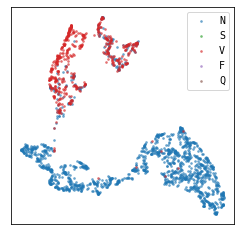

In [12]:
plt.figure(figsize=(4, 4))
for num, s in enumerate('NSVFQ'):
    plt.scatter(
        *fr[labels==s].T,
        s=3,
        c=f'C{num+(num!=0)}',
        alpha=0.5,
        label=s
    )
plt.legend()
plt.xticks([]); plt.yticks([])
plt.show(); plt.close()

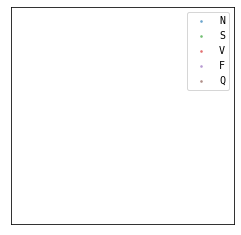

In [124]:
from tools import Embedder, Weighting, SineFilter

idx = 6
rng = np.random.default_rng(42)

segs = []; labels = []; lengths = []
beats_loc_symb = list(filter(lambda x: x[1] in 'NSVFQ', zip(ann_locs[idx], ann_symbols[idx])))
gap_max = np.max(np.diff([loc for loc, _ in beats_loc_symb]))
for num, (loc, symb) in enumerate(beats_loc_symb):
    if num == len(beats_loc_symb) - 1:
        continue
    loc_nxt, symb_nxt = beats_loc_symb[num + 1]
    loc = int(loc*250/340); loc_nxt = int(loc_nxt*250/340)

    lb, ub = loc-rng.integers(20, 50), loc_nxt+rng.integers(-10, 20)
    len_max = gap_max + 50 + 20
    if lb < 0 or ub >= ecg_filtered.shape[1]:
        continue
    segment = np.concatenate([np.full((len_max-ub+lb, ), ecg_filtered[idx, lb]), ecg_filtered[idx, lb:ub]], axis=0)
    segs.append(segment); labels.append(''.join(sorted(symb + symb_nxt))); lengths.append(ub-lb)
    # if symb == 'N':
    #     pass
    # elif symb == 'V':
    #     pass
segs = np.array(segs); labels = np.array(labels); lengths = np.array(lengths)

embedder = Embedder(dim=3, lag=4, reduce=0)
weighting = Weighting(method='exp')

x = embedder.transform(segs)
w = np.array([weighting.apply(el) for el in x])
w0 = np.zeros_like(w)
for i in range(w0.shape[0]):
    w0[-lengths[i]:] = 1/lengths[i]

from umap import UMAP

sine_filter = SineFilter(dim=3, scale=30, n_filters=32)
f = sine_filter.apply(x, w)
f0 = sine_filter.apply(x, w0)

reducer = UMAP(n_components=2, random_state=42)
fr = reducer.fit_transform(f)
# fr0 = reducer.fit_transform(f0)

plt.figure(figsize=(4, 4))
for num, s in enumerate('NSVFQ'):
    plt.scatter(
        *fr[labels==s].T,
        s=3,
        c=f'C{num+(num!=0)}',
        alpha=0.5,
        label=s
    )
plt.legend()
plt.xticks([]); plt.yticks([])
plt.show(); plt.close()

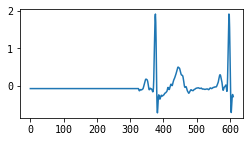

In [127]:
plt.figure(figsize=(4, 2))
plt.plot(segs[1600])

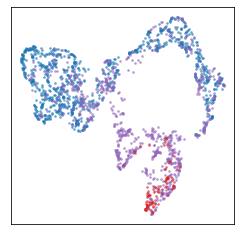

In [134]:
plt.figure(figsize=(4, 4))
for num, s in enumerate(['NN', 'NV', 'VV']):
    c = (0, 4, 3)[num]
    plt.scatter(
        *fr[labels==s].T,
        s=3,
        c=f'C{c}',
        alpha=0.5,
        label=s
    )
# plt.legend(fontsize=16, loc='lower right')
plt.xticks([]); plt.yticks([])
plt.show(); plt.close()

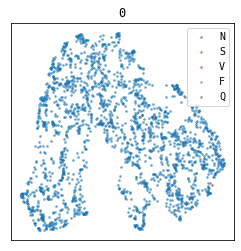

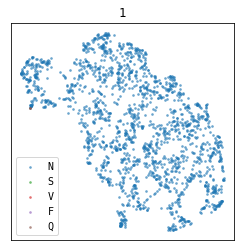

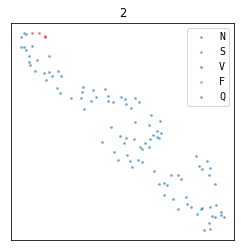

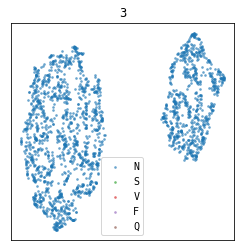

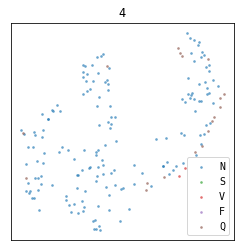

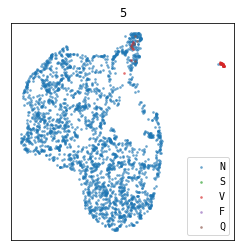

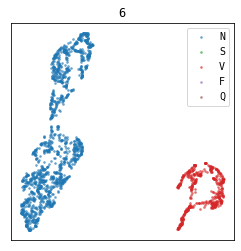

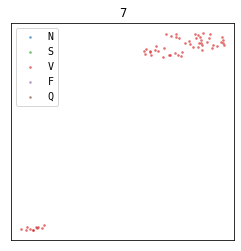

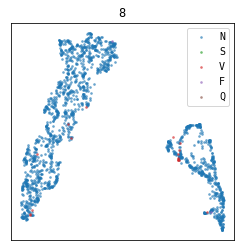

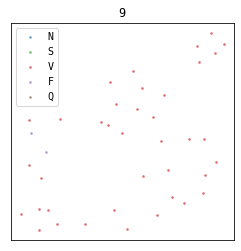

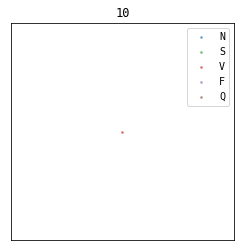

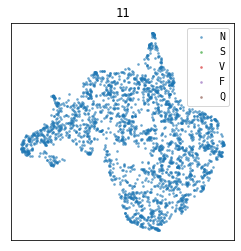

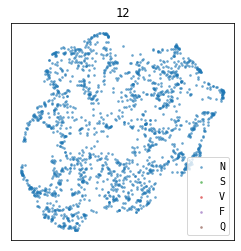

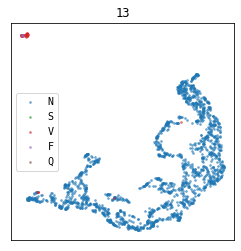

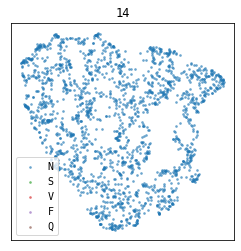

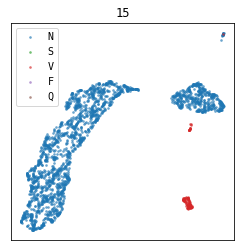

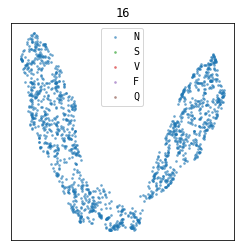

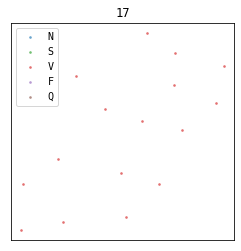

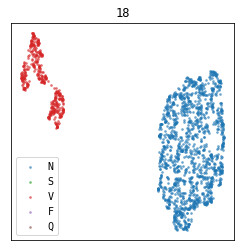

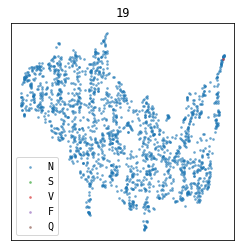

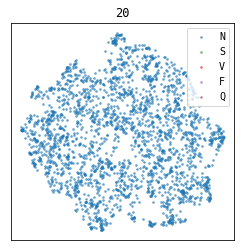

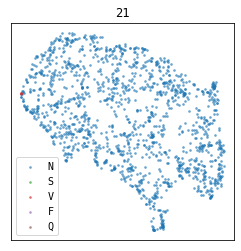

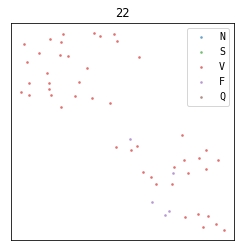

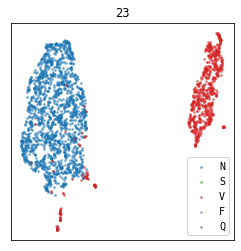

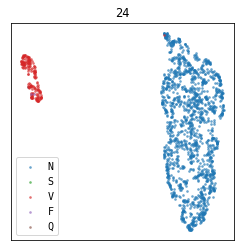

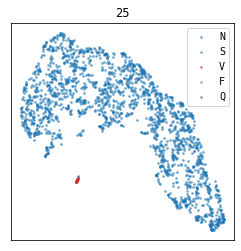

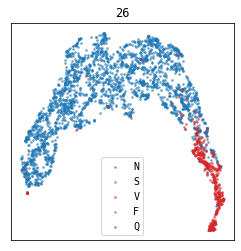

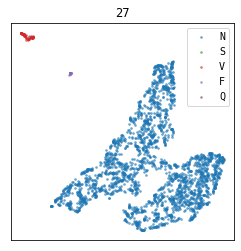

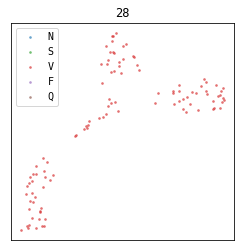

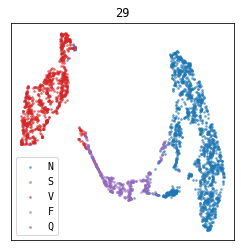

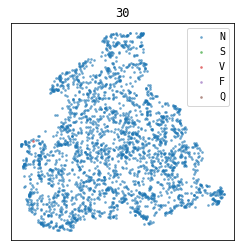

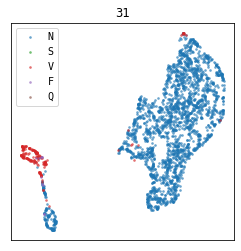

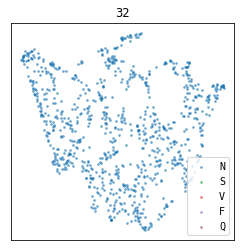

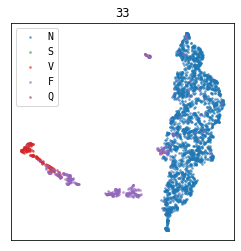

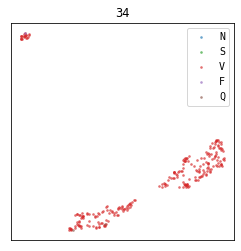

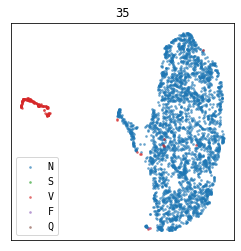

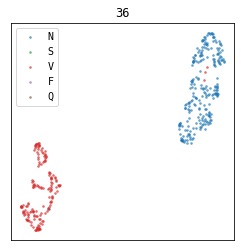

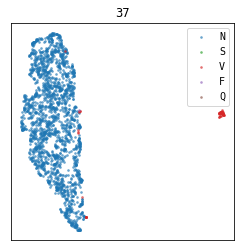

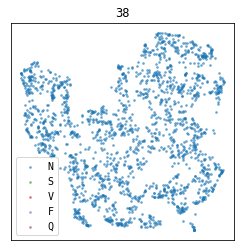

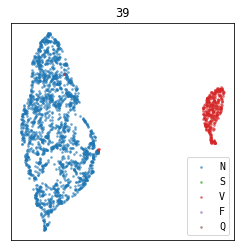

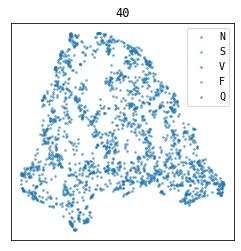

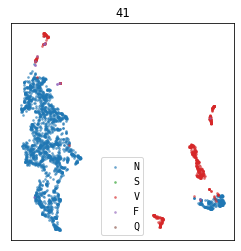

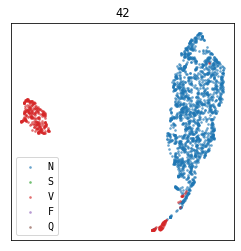

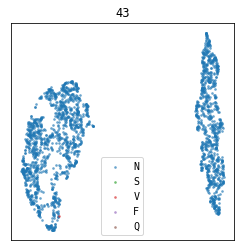

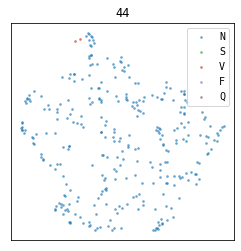

ValueError: operands could not be broadcast together with shapes (0,32) (0,) 

In [6]:
from tools import Embedder, Weighting, SineFilter

idx = 6
for idx in range(len(ann_locs)):
    rng = np.random.default_rng(42)

    segs = []; labels = []; lengths = []
    for loc, symb in zip(ann_locs[idx], ann_symbols[idx]):
        if symb not in 'NSVFQ':
            continue
        loc = int(loc*250/340)
        lb, ub = loc-rng.integers(60, 100), loc+rng.integers(60, 100)
        if lb < 0 or ub >= ecg_filtered.shape[1]:
            continue
        segment = np.concatenate([np.full((200-ub+lb, ), ecg_filtered[idx, lb]), ecg_filtered[idx, lb:ub]], axis=0)
        segs.append(segment); labels.append(symb); lengths.append(ub-lb)
        # if symb == 'N':
        #     pass
        # elif symb == 'V':
        #     pass
    segs = np.array(segs); labels = np.array(labels); lengths = np.array(lengths)

    embedder = Embedder(dim=3, lag=4, reduce=0)
    weighting = Weighting(method='exp')

    x = embedder.transform(segs)
    w = np.array([weighting.apply(el) for el in x])
    w0 = np.zeros_like(w)
    for i in range(w0.shape[0]):
        w0[-lengths[i]:] = 1/lengths[i]

    from umap import UMAP

    sine_filter = SineFilter(dim=3, scale=30, n_filters=32)
    f = sine_filter.apply(x, w)
    f0 = sine_filter.apply(x, w0)

    reducer = UMAP(n_components=2, random_state=42)
    fr = reducer.fit_transform(f)
    # fr0 = reducer.fit_transform(f0)

    plt.figure(figsize=(4, 4))
    for num, s in enumerate('NSVFQ'):
        plt.scatter(
            *fr[labels==s].T,
            s=3,
            c=f'C{num+(num!=0)}',
            alpha=0.5,
            label=s
        )
    plt.legend()
    plt.xticks([]); plt.yticks([])
    plt.title(idx)
    plt.show(); plt.close()